In [1]:
!pip install umap-learn

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/opt/homebrew/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [18]:
from sentence_transformers import SentenceTransformer
import umap 

import pandas as pd 
import re
import numpy as np 

In [3]:
df = pd.read_csv("archive/TheOffice_transcripts.csv", on_bad_lines= 'skip')

df.columns = ["sentence"]

In [5]:
for i in range(len(df)):

    string = str(df["sentence"][i])
    seperator = ';'
    df["sentence"][i] = string.split(seperator, 1)[0]

    string = str(df["sentence"][i])
    seperator = ':'
    df["sentence"][i] = string.split(seperator, 1)[-1]

    string = str(df["sentence"][i])
    normal_string =re.sub("[^A-Z]", "", string,0,re.IGNORECASE)


In [6]:
df

,sentence
0,All right Jim. Your quarterlies look very goo...
1,Well. I don't know.
2,What?
3,Any messages?
4,You haven't told me.
...,...
34028,I'm going to miss this incredible family here ...
34029,This has been my other family for nine years. ...
34030,And it's a tough thing.
34031,It's just been everything to me.


In [7]:
model = SentenceTransformer("all-mpnet-base-v2")

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [19]:
"""
Putting sentences into a list 
"""
sentences = df["sentence"].values.tolist()

embeddings = model.encode(sentences)

embeddings = np.array(embeddings)

In [20]:
!pip install pynndescent

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/opt/homebrew/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [33]:
"""
n_components = what is the final dimension you are reducing to
"""
import pynndescent
def correct_alternative_cosine(ds):
    result = np.empty_like(ds)
    for i in range(ds.shape[0]):
        result[i] = 1.0 - np.power(2.0, ds[i])
    return result
pynn_dist_fns_fda = pynndescent.distances.fast_distance_alternatives
pynn_dist_fns_fda["cosine"]["correction"] = correct_alternative_cosine
pynn_dist_fns_fda["dot"]["correction"] = correct_alternative_cosine

umap_embeddings = umap.UMAP(n_neighbors=50, n_components=2, min_dist = 0.0, metric='cosine').fit_transform(embeddings)

In [23]:
!pip install hdbscan

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 4.0 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.32-py2.py3-none-any.whl (986 kB)
  Created wheel for hdbscan: filename=hdbscan-0.8.29-cp39-cp39-macosx_12_0_arm64.whl size=636845 sha256=f69f8daa6eff837f29a1f04e0e838

In [31]:
import hdbscan

cluster = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean').fit(umap_embeddings)

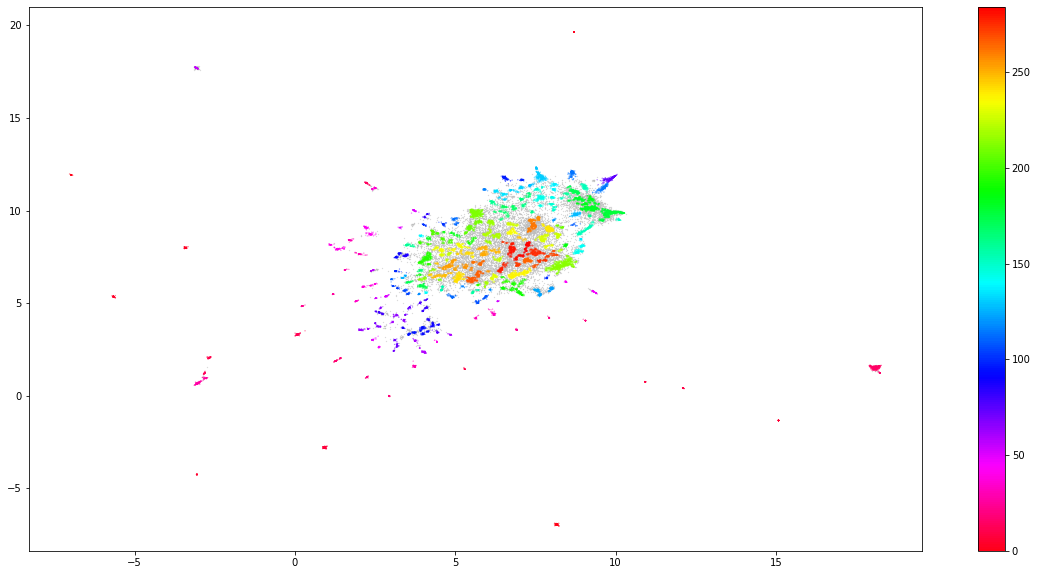

In [32]:
import matplotlib.pyplot as plt

result = pd.DataFrame(umap_embeddings, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()